## ToDo List
- [x] Checar se formato de datas conferem.
- [x] Remover UGs sem liberação OC
- [x] Considerar coluna montagem. Onde estiver vazio, pegar valor de Torres para EOL, no skate.
- [ ] Separar um cojunto aleatório para teste
- [x] Calcular tempos de construção por marco: (IO_realizado - realizado), (CC_realizado - realizado) ...etc  (ordem:IO,CC,ME,OT)
- [x] Calcular atraso da operação comercial (realizado - outorgado)
- [x] Calcular média e dp do tempo de construção.
- [x] Calcular data dos marcos medios (outorgado - tempo_medio_de_construcao) por fonte.
- [x] Calcular atrasos com base nos marcos medios
- [ ] Calcular media e dp dos atrasos. 
- [ ] Normalizar os atrasos calculados (atraso - atraso_medio)/dp
- [x] Construir matriz de correlação de Pearson
- [ ] Calcular os coeficientes para regressão linear
- [x] Para UHE pegar todas UGs, para as demais pegar a primeira UG apenas 
- [ ] Comparar pegando primeira UG e media por grupo



In [1]:
import pandas as pd
import numpy as np
import re
import pyodbc
from pprint import pprint
import matplotlib.pyplot as plt
#from sklearn.linear_model import LinearRegression
from scipy import stats

from itertools import combinations

In [2]:
def outliers(df:pd.DataFrame,cols : list):
    index_outliers =  []
    for col in cols:
        s = df[col]
        Q1 = s.quantile(0.1)
        Q3 = s.quantile(0.9)
        lower_bound =  Q1
        upper_bound =  Q3 
        index_outliers.extend(s.index[(s < lower_bound) | (s > upper_bound)])
    return set(index_outliers)

#### Transforma coluna IdeUsinaOutorga das UHEs para que cada UG possua esse campo diferente. Por exemplo as UGs da usina 12 serão 12_0, 12_1...

In [3]:
bd_combined = pd.read_parquet("bd_combined.gzip")

In [4]:
bd_combined[bd_combined.IdeUsinaOutorga==27339]

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
95,27339,2017-04-01,2017-05-01,2018-07-28,2018-08-21,SP,11.0,NaT,2016-11-15,NaT,...,None,NaT,NaT,NaT,2016-11-15,UTE,1,6.0,bdworgs,None
96,27339,NaT,1994-01-01,1994-01-01,1994-01-01,SP,11.0,NaT,2016-11-15,NaT,...,None,NaT,NaT,NaT,2016-11-15,UTE,1,5.0,bdworgs,None


In [5]:
bd_combined.index.name = "idx"
bd_combined.IdeUsinaOutorga = bd_combined.IdeUsinaOutorga.astype(str)
mask = (bd_combined.SigTipoGeracao == "UHE") & (bd_combined.IdeUsinaOutorga.duplicated(keep=False))
bd_combined.loc[mask,"IdeUsinaOutorga"] = bd_combined.loc[mask,"IdeUsinaOutorga"] +"_"+ bd_combined.loc[mask].groupby("IdeUsinaOutorga").cumcount().astype(str)
bd_combined.sample(15)

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
80,26874,NaT,NaT,2013-04-05,2013-05-25,SP,73.000,NaT,NaT,NaT,...,None,NaT,NaT,NaT,NaT,UTE,1,40.000,bdworgs,None
4496,40696,2022-11-28,2022-12-28,NaT,NaT,BA,17100.000,2022-01-18,NaT,2022-03-10,...,None,NaT,NaT,2021-10-31,NaT,EOL,1,5700.000,skate,2020-05-19
3926,37518,2021-06-16,2022-02-28,NaT,NaT,BA,59800.000,2021-09-21,NaT,NaT,...,None,NaT,NaT,2020-09-02,NaT,UFV,1,4600.000,skate,2020-03-03
3834,37104,2023-12-02,2024-01-01,2020-07-29,2020-08-14,BA,50400.000,2023-01-31,2019-07-15,2023-04-01,...,None,NaT,NaT,2023-01-31,2019-05-01,EOL,1,4200.000,skate,2018-12-27
115,27729,NaT,2003-07-05,2010-10-07,2010-10-15,MG,9.000,2001-09-01,2009-04-15,NaT,...,None,NaT,2010-09-23,NaT,NaT,PCH,2,9.000,bdworgs,None
1713,31750,2018-03-30,2018-04-30,2016-07-23,2016-08-17,RN,24.000,2017-09-01,2016-01-19,2017-11-01,...,2016-04-15,NaT,NaT,2017-07-01,2015-02-15,EOL,8,24.000,bdworgs,None
1771,31821,2016-12-15,2017-01-01,2016-04-19,2016-05-25,PE,29.155,2016-03-15,2015-09-15,2016-05-01,...,2016-01-15,NaT,NaT,2016-04-01,2015-09-28,EOL,17,29.155,bdworgs,None
2184,34420,2016-02-25,2016-03-25,2019-03-26,2019-06-25,RO,0.742,2016-11-15,2016-03-24,NaT,...,None,NaT,NaT,2016-01-30,2016-05-14,UTE,4,0.742,bdworgs,None
1904,32366,2017-09-15,2017-10-01,2017-03-09,2017-06-14,PI,27.600,2016-12-13,2016-09-30,2017-01-29,...,2016-11-18,NaT,NaT,2016-12-30,2016-07-15,EOL,2,4.600,bdworgs,None


In [6]:
bd_combined[bd_combined.IdeUsinaOutorga=="27339"]

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
95,27339,2017-04-01,2017-05-01,2018-07-28,2018-08-21,SP,11.0,NaT,2016-11-15,NaT,...,None,NaT,NaT,NaT,2016-11-15,UTE,1,6.0,bdworgs,None
96,27339,NaT,1994-01-01,1994-01-01,1994-01-01,SP,11.0,NaT,2016-11-15,NaT,...,None,NaT,NaT,NaT,2016-11-15,UTE,1,5.0,bdworgs,None


#### Remove linhas cujas colunas DatUGInicioOpComerOutorgado e DatLiberOpComerRealizado não sejam nulas

In [7]:
bd_combined = bd_combined[bd_combined.DatUGInicioOpComerOutorgado.notna()
                            & bd_combined.DatLiberOpComerRealizado.notna()].copy(deep=True)

In [8]:
bd_combined[bd_combined.IdeUsinaOutorga=="27339"]

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
95,27339,2017-04-01,2017-05-01,2018-07-28,2018-08-21,SP,11.0,NaT,2016-11-15,NaT,...,None,NaT,NaT,NaT,2016-11-15,UTE,1,6.0,bdworgs,None
96,27339,NaT,1994-01-01,1994-01-01,1994-01-01,SP,11.0,NaT,2016-11-15,NaT,...,None,NaT,NaT,NaT,2016-11-15,UTE,1,5.0,bdworgs,None


In [9]:
nomes_tempo_construcao = {
    "IO_OC" : "DatInicioObraRealizado",
    "CC_OC" : "DatConcretagemRealizado",
    "ME_OC" : "DatMontagemRealizado",
    "OT_OC" : "DatLiberacaoSFGTeste"
} 

tempo_construcao_por_UG = bd_combined[["IdeUsinaOutorga","SigTipoGeracao"]].copy(deep=True)
for nome,marco in nomes_tempo_construcao.items():
    tempo_construcao_por_UG[nome] = bd_combined["DatLiberOpComerRealizado"]-  bd_combined[marco]

tempo_construcao_por_UG["Atraso"]  =  bd_combined["DatLiberOpComerRealizado"]-  bd_combined["DatUGInicioOpComerOutorgado"] 
tempo_construcao_por_UG.head(25)

,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,
0,12_0,UHE,1532 days,855 days,NaT,8 days,665 days
1,12_1,UHE,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,581 days,NaT,NaT,6 days,2299 days
3,42_0,UHE,1521 days,NaT,NaT,10 days,608 days
4,42_1,UHE,1553 days,NaT,NaT,11 days,0 days
5,42_2,UHE,1615 days,NaT,NaT,24 days,0 days
6,127,UTE,561 days,NaT,NaT,NaT,15 days
7,161,PCH,1163 days,677 days,NaT,38 days,2290 days
9,291,PCH,697 days,419 days,NaT,45 days,1676 days


In [10]:
is_first = True 
combinacoes = list(combinations([x for x in tempo_construcao_por_UG.columns if x not in ["IdeUsinaOutorga","SigTipoGeracao","Atraso"]],2))
#combinacoes = list(combinations(["IO","CC","ME","MT","OT"],2))

for p_marco, s_marco in combinacoes:
    idx_loop =  ((tempo_construcao_por_UG[p_marco] >= tempo_construcao_por_UG[s_marco]) | 
                 tempo_construcao_por_UG[p_marco].isna() | 
                 tempo_construcao_por_UG[s_marco].isna())

    idx = idx_loop if is_first else (idx & idx_loop)
    is_first = False 

#idx_usinas = idx & (tempo_construcao_por_UG.IO_OC.notna())
tempo_construcao_por_UG_filtered = tempo_construcao_por_UG[idx].copy(deep=True)
tempo_construcao_por_UG_filtered

,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,
0,12_0,UHE,1532 days,855 days,NaT,8 days,665 days
1,12_1,UHE,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,581 days,NaT,NaT,6 days,2299 days
3,42_0,UHE,1521 days,NaT,NaT,10 days,608 days
4,42_1,UHE,1553 days,NaT,NaT,11 days,0 days
...,...,...,...,...,...,...,...
5752,50872,UTE,98 days,NaT,98 days,41 days,-920 days
5776,51444,UTE,99 days,NaT,99 days,22 days,-385 days
5782,51450,UTE,104 days,NaT,104 days,26 days,-380 days


In [11]:
tempo_construcao_por_UG[~idx]

,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,
96,27339,UTE,-8354 days,NaT,NaT,0 days,0 days
223,28462,UTE,-1560 days,NaT,NaT,71 days,180 days
292,28780,PCH,885 days,454 days,546 days,79 days,349 days
293,28780,PCH,885 days,454 days,546 days,79 days,318 days
448,29122,UTE,-202 days,NaT,NaT,31 days,-1101 days
...,...,...,...,...,...,...,...
4557,40879,EOL,533 days,340 days,121 days,144 days,145 days
4569,40884,EOL,207 days,293 days,141 days,27 days,16 days
4570,40884,EOL,221 days,307 days,155 days,41 days,30 days


In [12]:
idx_primeira_ug =  bd_combined[idx].groupby(["IdeUsinaOutorga"],sort=False).DatLiberOpComerRealizado.idxmin()
bd_combined_usinas =   bd_combined.loc[idx_primeira_ug,:]
bd_combined_usinas.sample(10)

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,Torres_Real,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
2052,33664,2018-11-20,2019-01-01,2017-10-14,2017-10-31,PB,31.50,2018-03-01,2017-01-15,2018-06-01,...,2017-07-15,NaT,NaT,2018-01-30,2016-12-15,EOL,15,31.50,bdworgs,None
13,612,2009-07-17,2009-12-31,2010-12-16,2011-02-08,PB,169.08,2008-07-18,2008-07-15,NaT,...,None,NaT,NaT,NaT,NaT,UTE,20,169.08,bdworgs,None
106,27576,NaT,2003-05-01,2010-11-30,2011-01-03,MG,10.00,2001-09-01,2009-07-01,NaT,...,None,NaT,NaT,NaT,NaT,PCH,2,10.00,bdworgs,None
1164,30695,2013-12-10,2014-01-01,2014-07-21,2014-09-25,CE,21.60,NaT,2013-04-15,NaT,...,2014-04-15,NaT,NaT,NaT,2013-05-02,EOL,8,21.60,bdworgs,None
3650,35753,2019-10-01,2019-11-15,2019-12-21,2020-07-22,SC,11700.00,2018-05-01,2018-06-15,2018-06-01,...,None,2019-09-30,2019-12-15,2019-02-15,2018-10-30,PCH,2,11700.00,skate,2017-07-18
469,29159,2006-09-15,2006-10-30,2009-09-01,2009-11-27,SC,14.68,2005-05-01,2007-08-21,2005-11-01,...,None,NaT,2009-05-29,NaT,NaT,PCH,5,14.68,bdworgs,None
1594,31578,2015-11-13,2016-01-01,2015-10-15,2015-12-16,RS,12.53,2014-11-21,2015-01-15,2015-04-10,...,2015-05-09,NaT,NaT,2014-10-29,2014-11-15,EOL,7,12.53,bdworgs,None
636,29707_14,2013-09-01,2014-01-01,2013-06-05,2013-08-19,RO,3568.00,2008-12-01,2008-09-15,2010-04-01,...,None,2011-11-15,2012-01-23,NaT,2010-10-01,UHE,1,73.29,bdworgs,None
411,29059,2006-08-01,2006-12-01,2009-10-24,2009-11-14,TO,30.00,2004-07-01,2006-09-01,2004-08-01,...,None,NaT,NaT,NaT,NaT,PCH,3,30.00,bdworgs,None


In [13]:
# Atrasos por usinas são calculados com base UG com menor atraso.
tempo_construcao_por_usina = tempo_construcao_por_UG_filtered.loc[idx_primeira_ug,:]
#tempo_construcao_por_usina.set_index(keys = "IdeUsinaOutorga",inplace=True)
tempo_construcao_por_usina

,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,
0,12_0,UHE,1532 days,855 days,NaT,8 days,665 days
1,12_1,UHE,1609 days,932 days,NaT,12 days,192 days
2,19,UTE,581 days,NaT,NaT,6 days,2299 days
3,42_0,UHE,1521 days,NaT,NaT,10 days,608 days
4,42_1,UHE,1553 days,NaT,NaT,11 days,0 days
...,...,...,...,...,...,...,...
5752,50872,UTE,98 days,NaT,98 days,41 days,-920 days
5776,51444,UTE,99 days,NaT,99 days,22 days,-385 days
5782,51450,UTE,104 days,NaT,104 days,26 days,-380 days


In [120]:
def divide(a,b):
    mask = a.notna()
    if len(a[mask])>0:
        a[mask] = a[mask]/b
    else:
        pass
    return a

tipos_geracao = tempo_construcao_por_geracao.index.to_list()
tempo_construcao_por_usina_norm = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao"]]
tempo_construca_mean_dp = {}
for SigTipoGeracao in tipos_geracao:
    tempo_construca_mean_dp[SigTipoGeracao] = {}
    for tempo in ["IO_OC","CC_OC","ME_OC","OT_OC","Atraso"]:
        tempo_construca_mean_dp[SigTipoGeracao][tempo] = {}
        mask = tempo_construcao_por_usina.SigTipoGeracao==SigTipoGeracao
        m = tempo_construcao_por_usina.loc[mask,tempo].mean()
        s= tempo_construcao_por_usina.loc[mask,tempo].std()
        tempo_construca_mean_dp[SigTipoGeracao][tempo]["media"] = m.days/30
        tempo_construca_mean_dp[SigTipoGeracao][tempo]["dp"] = s.days/30
        tempo_construcao_por_usina_norm.loc[mask,tempo] = divide((tempo_construcao_por_usina.loc[mask,tempo] - m),s)   
tempo_construcao_por_usina_norm


,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,OT_OC,Atraso
idx,,,,,,,
0,12_0,UHE,-0.510674,-1.267459,NaN,-0.671693,0.830213
1,12_1,UHE,-0.385251,-1.140075,NaN,-0.609173,-0.021921
2,19,UTE,-0.137639,NaT,NaN,-0.63144,2.862015
3,42_0,UHE,-0.528592,NaT,NaN,-0.640433,0.727525
4,42_1,UHE,-0.476468,NaT,NaN,-0.624803,-0.36782
...,...,...,...,...,...,...,...
5752,50872,UTE,-0.769889,NaN,-0.515903,-0.407591,-1.738998
5776,51444,UTE,-0.76858,NaN,-0.514677,-0.529109,-0.974306
5782,51450,UTE,-0.762035,NaN,-0.508543,-0.503526,-0.96716


In [14]:
# Cria tabela para calculos por geracao
tempo_construcao_por_geracao = pd.DataFrame()
tempo_construcao_por_geracao["SigTipoGeracao"] = bd_combined.SigTipoGeracao.unique() 


# Realiza calculos por geracao
for coluna in tempo_construcao_por_usina.columns:
    if coluna not in ["IdeUsinaOutorga","SigTipoGeracao"]:
        tempo_construcao_por_geracao[f"{coluna}_media"] = tempo_construcao_por_geracao.SigTipoGeracao.apply(lambda x : tempo_construcao_por_usina[tempo_construcao_por_usina.SigTipoGeracao==x][coluna].mean())
        #tempo_construcao_por_geracao[f"{coluna}_std"] = tempo_construcao_por_geracao.SigTipoGeracao.apply(lambda x : tempo_construcao_por_usina[tempo_construcao_por_usina.SigTipoGeracao==x][coluna].std())

tempo_construcao_por_geracao.set_index("SigTipoGeracao",inplace=True)
display(tempo_construcao_por_geracao)

,IO_OC_media,CC_OC_media,ME_OC_media,OT_OC_media,Atraso_media
SigTipoGeracao,,,,,
UHE,1845 days 12:18:46.956521728,1621 days 03:27:45.671641792,1516 days 07:42:13.333333328,50 days 23:23:04.615384615,204 days 04:02:01.008403362
UTE,686 days 03:32:05.581395352,NaT,518 days 12:51:14.157303368,104 days 17:30:13.533834586,296 days 15:39:25.714285716
PCH,876 days 02:01:03.716814160,644 days 20:41:08.571428568,402 days 15:49:56.858638744,50 days 12:36:08.339768340,993 days 17:03:00.694980688
CGH,895 days 13:55:12,666 days 22:28:05.106382976,480 days 01:12:00,103 days 00:48:48.813559322,415 days 05:36:00
EOL,561 days 17:28:45.746799432,493 days 03:34:14.935622320,357 days 22:04:08.275862068,58 days 14:10:04.267425320,66 days 12:15:21.763869132
UFV,376 days 21:46:29.403973508,NaT,244 days 08:09:36,70 days 22:24:38.145695364,-5 days +20:20:39.735099338


In [15]:
marco_medio_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga"]]
def id_marco(ID,nome,marco):
    geracao = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"SigTipoGeracao"].values[0]
    tempo_medio = tempo_construcao_por_geracao.loc[geracao,f"{nome}_media"]
    data_OC = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"DatUGInicioOpComerOutorgado"].values[0]
    data_marco_medio = data_OC - tempo_medio
    return data_marco_medio


for nome,marco in nomes_tempo_construcao.items():
    marco_medio_usina[f"{marco}_estimado"] = marco_medio_usina.IdeUsinaOutorga.apply(lambda ID :  id_marco(ID,nome,marco))

In [16]:
marco_medio_usina

,IdeUsinaOutorga,DatInicioObraRealizado_estimado,DatConcretagemRealizado_estimado,DatMontagemRealizado_estimado,DatLiberacaoSFGTeste_estimado
idx,,,,,
0,12_0,2002-02-09 11:41:13.043478272,2002-09-21 20:32:14.328358208,2003-01-04 16:17:46.666666672,2007-01-09 00:36:55.384615385
1,12_1,2003-08-13 11:41:13.043478272,2004-03-24 20:32:14.328358208,2004-07-07 16:17:46.666666672,2008-07-12 00:36:55.384615385
2,19,2000-02-14 20:27:54.418604648,NaT,2000-07-31 11:08:45.842696632,2001-09-18 06:29:46.466165414
3,42_0,1998-11-10 11:41:13.043478272,1999-06-22 20:32:14.328358208,1999-10-05 16:17:46.666666672,2003-10-10 00:36:55.384615385
4,42_1,2000-08-11 11:41:13.043478272,2001-03-23 20:32:14.328358208,2001-07-06 16:17:46.666666672,2005-07-11 00:36:55.384615385
...,...,...,...,...,...
5752,50872,2022-07-10 20:27:54.418604648,NaT,2022-12-25 11:08:45.842696632,2024-02-12 06:29:46.466165414
5776,51444,2021-05-14 20:27:54.418604648,NaT,2021-10-29 11:08:45.842696632,2022-12-17 06:29:46.466165414
5782,51450,2021-05-14 20:27:54.418604648,NaT,2021-10-29 11:08:45.842696632,2022-12-17 06:29:46.466165414


In [17]:
atraso_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao","Atraso"]]
nomes_colunas_atrasos = []
for nome,marco in nomes_tempo_construcao.items():
    nome_coluna = f"{marco}_atraso"
    nomes_colunas_atrasos.append(nome_coluna)
    atraso_usina[nome_coluna] = bd_combined_usinas[marco] - marco_medio_usina[f"{marco}_estimado"]

In [18]:
atraso_usina.sample(10)

,IdeUsinaOutorga,SigTipoGeracao,Atraso,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatLiberacaoSFGTeste_atraso
idx,,,,,,,
2167,34373,UTE,233 days,NaT,NaT,NaT,333 days 17:30:13.533834586
719,29736_11,UHE,459 days,385 days 12:18:46.956521728,192 days 03:27:45.671641792,177 days 07:42:13.333333328,476 days 23:23:04.615384615
704,29733,PCH,96 days,94 days 02:01:03.716814160,216 days 20:41:08.571428568,294 days 15:49:56.858638744,135 days 12:36:08.339768340
1040,30468,EOL,14 days,-277 days +17:28:45.746799432,-315 days +03:34:14.935622320,-222 days +22:04:08.275862068,49 days 14:10:04.267425320
3748,36984,EOL,-567 days,-320 days +17:28:45.746799432,-357 days +03:34:14.935622320,-357 days +22:04:08.275862068,-540 days +14:10:04.267425320
4029,37716,UTE,597 days,559 days 03:32:05.581395352,NaT,487 days 12:51:14.157303368,389 days 17:30:13.533834586
2103,33757,UFV,228 days,237 days 21:46:29.403973508,NaT,227 days 08:09:36,253 days 22:24:38.145695364
4398,40595,EOL,-348 days,-183 days +17:28:45.746799432,-195 days +03:34:14.935622320,-155 days +22:04:08.275862068,-394 days +14:10:04.267425320
484,29201,UTE,197 days,323 days 03:32:05.581395352,NaT,542 days 12:51:14.157303368,218 days 17:30:13.533834586


Não foi possível calcular: DatConcretagemRealizado_atraso para UTE
Não foi possível calcular: DatConcretagemRealizado_atraso para UFV


,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatLiberacaoSFGTeste_atraso
UHE,56.6%,63.1%,35.7%,99.3%
UTE,54.3%,-,51.6%,97.4%
PCH,87.8%,89.4%,95.7%,97.7%
CGH,55.6%,72.4%,81.9%,98.8%
EOL,77.2%,77.0%,80.4%,99.7%
UFV,92.7%,-,93.4%,98.0%


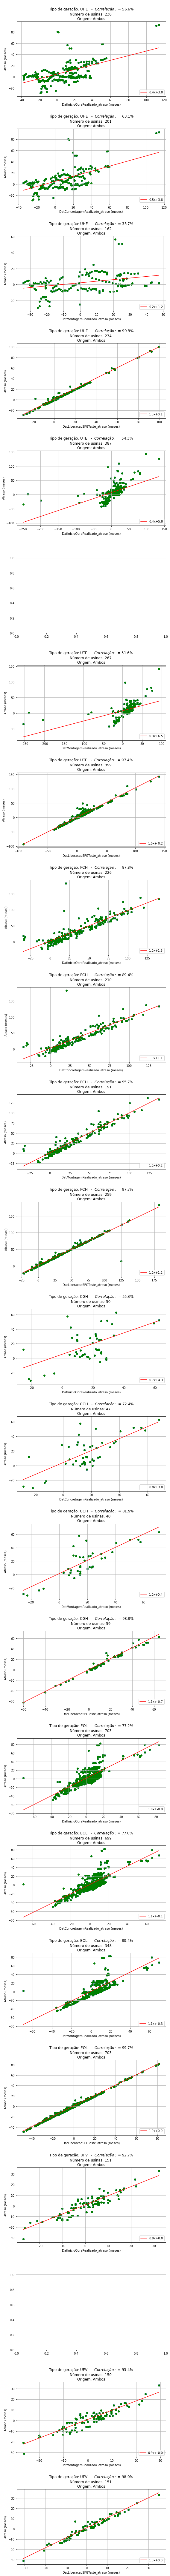

In [145]:
plot_created = False
analises_origem =["Ambos"]     #["skate","bdworgs","Ambos"]
tempo_construcao_nomes = {v: k for k, v in nomes_tempo_construcao.items()}

matrix_pearson = {}

for k,origem in enumerate(analises_origem):
    
    if not plot_created:    
        num_subplots = (len(tipos_geracao))*(len(nomes_colunas_atrasos))
        fig, axes = plt.subplots(num_subplots,len(analises_origem),figsize=(len(analises_origem)*8,num_subplots*5))
        plot_created =True
    count = -1
    for i,SigTipoGeracao in enumerate(tipos_geracao):
        matrix_pearson[SigTipoGeracao] = []
        for nome_coluna in nomes_colunas_atrasos:
            count+=1
            try:
                ordered_notna = atraso_usina[(atraso_usina[nome_coluna].notna())
                                                 & (atraso_usina.SigTipoGeracao == SigTipoGeracao) ].sort_values(by = nome_coluna)
                x = ordered_notna[nome_coluna].dt.days.to_numpy().reshape(-1, 1)/30
                y = ordered_notna["Atraso"].dt.days.to_numpy().reshape(-1, 1)/30
                res = stats.linregress(x.flatten(), y.flatten())
                a, b, r, p_value, std_err = res
                r_str = f"{100*r:.1f}%"
                matrix_pearson[SigTipoGeracao].append(r_str)
                ax = axes[count]
                ax.scatter(x,y,color="blue")
                ax.set_xlabel(f"{nome_coluna} (meses)")
                ax.set_ylabel(f"Atraso (meses)")
                ax.plot(x,a*x+b+1,color="red",label= f"{a:.1f}x+{b:.1f}")
                
                media = tempo_construca_mean_dp[SigTipoGeracao][tempo_construcao_nomes[nome_coluna[:-7]]]["media"]
                dp  = tempo_construca_mean_dp[SigTipoGeracao][tempo_construcao_nomes[nome_coluna[:-7]]]["dp"]
                outliers = ((tempo_construcao_por_usina_norm[tempo_construcao_nomes[nome_coluna[:-7]]]) > 2*dp)| ((tempo_construcao_por_usina_norm[tempo_construcao_nomes[nome_coluna[:-7]]]) < 2*dp)

                
                ordered_notna = atraso_usina[(atraso_usina[nome_coluna].notna())
                                                 & (atraso_usina.SigTipoGeracao == SigTipoGeracao) & (outliers) ].sort_values(by = nome_coluna)
                x = ordered_notna[nome_coluna].dt.days.to_numpy().reshape(-1, 1)/30
                y = ordered_notna["Atraso"].dt.days.to_numpy().reshape(-1, 1)/30
                ax.scatter(x,y,color="green")
                
                
                ax.set_title(f"\nTipo de geração: {SigTipoGeracao}   -  $Correlação:$ = {r_str}\nNúmero de usinas: {x.shape[0]} \nOrigem: {origem}")
                ax.legend(loc="lower right")
                ax.grid()
                
               
            except (ValueError,AttributeError) as error:
                print(rf"Não foi possível calcular: {nome_coluna} para {SigTipoGeracao}")
                matrix_pearson[SigTipoGeracao].append("-")
matrix_pearson =  pd.DataFrame(matrix_pearson,nomes_colunas_atrasos)
display(matrix_pearson.T)
plt.tight_layout()
plt.savefig("calculos_atrasos.pdf")
person_matrix = pd.DataFrame(matrix_pearson,nomes_colunas_atrasos)

idx
0       False
1       False
2       False
3       False
4       False
        ...  
5752    False
5776    False
5782    False
5810    False
5943    False
Name: OT_OC, Length: 1831, dtype: bool

In [140]:
dp

1.9666666666666666

In [88]:
nomes_tempo_construcao

{'IO_OC': 'DatInicioObraRealizado',
 'CC_OC': 'DatConcretagemRealizado',
 'ME_OC': 'DatMontagemRealizado',
 'OT_OC': 'DatLiberacaoSFGTeste'}

'OT_OC'